## Smoothing the Data using Kalman Filtering

Applies Kalman Filtering to the raw 297/58/53 town data as it was quite noisy. Took a few (too many) goes to get working, but finally does a good job. Have still kept the individual Kalman filtering in there just for reference.

In [30]:
# Import the many necessary libraries
import pandas as pd
import os
import numpy as np
import filterpy as fp
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt
import math
import networkx as nx
import time
import scipy

In [31]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import inv
from scipy.sparse import identity
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix

First, create a dictionary where each entry is a dataframe of the adjacency matrix.

In [32]:
fl = sorted(os.listdir("/Volumes/HardDrive/New_Workflow/44_towns_network/"))

In [33]:
wa_flow = []
for item in fl:
    if '._' not in item:
        wa_flow.append(item)

In [34]:
d = {}
for i in range(len(wa_flow)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/44_towns_network/"+wa_flow[i], header = None)

In [35]:
len(d)

97

In [36]:
len(wa_flow)

97

In [37]:
# Define some global variables
b = 44
big = 44**2
weeks = len(d)

Create a list (allvals) which includes every value from every dataframe as one long list

In [38]:
allvals = []
for i in range(len(d.values())):
    l = d[str(i)].values.tolist()
    av = []
    for i in l:
        for k in i:
            av.append(k)
            allvals.append(k)

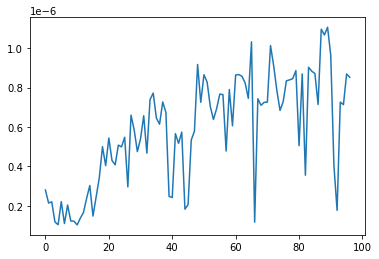

In [39]:
#Create a vector of all entries of a particular edge during all weeks from allvals
def timeseries_vector(x): 
    timeseries = []
    for i in range(weeks):
        timeseries.append(allvals[x+(big)*i])
    return timeseries
ts = timeseries_vector(3)
plt.plot(ts)

**Individual (edge by edge) Kalman Filter:**

This Kalman filter treats the time series of each edge as an individual entity and does a Kalman filter on that.

In [40]:
def kalman_gain(r,q, kalmans):
    # Kalman gain formula
    prev = kalmans[-1]
    kalmans.append( ((prev + q)**(-1)+1/r)**(-1) )
    return kalmans

In [41]:
mean = np.mean(allvals)
std = np.std(allvals)

In [42]:
def filtering(timeseries,r,q,mean,std):
    updated = [np.mean(timeseries)]
    inn = []
    kg = [((std**2 + q)**(-1) + 1/r)**(-1)]
    for t in timeseries:
        kg = kalman_gain(r,q,kg)
        
        # Updating of the data formula
        up = updated[-1] + kg[-1]*(r)**(-1)*(t - updated[-1])
        
        inn.append(t-updated[-1])
        updated.append(up)
        
    updated = updated[1:]
    return updated, kg, inn

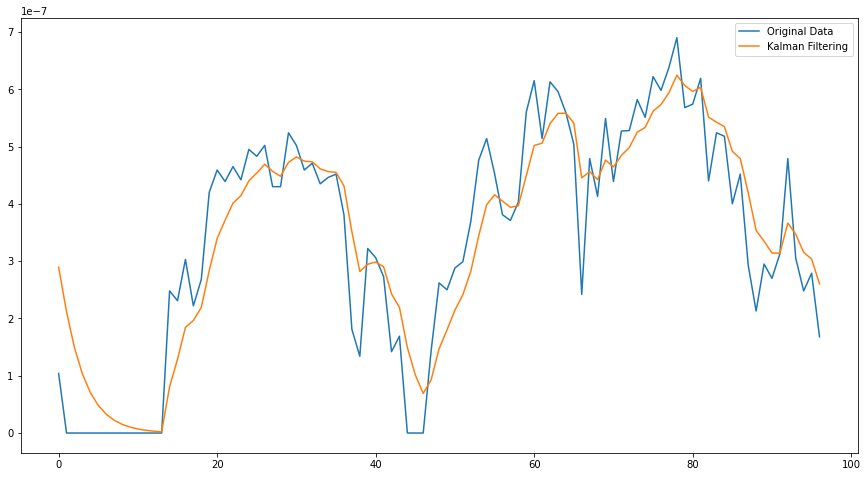

In [43]:
# E.g. just one edge
ts = timeseries_vector(7)
plt.figure(figsize = (15,8))
plt.plot(ts, label = 'Original Data')
f, kg, inn = filtering(ts, 2, 0.3, mean, std)
plt.plot(f, label = 'Kalman Filtering')
plt.legend()

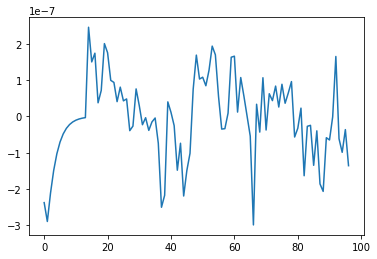

In [44]:
#Plot the innovations and make sure that they oscillate or at least don't converge.
plt.figure()
plt.plot(inn)

In [45]:
#Run a Kalman on each edge:
allkal = []
for i in range(big):
    ts = timeseries_vector(i)
    if all(0 == t for t in timeseries_vector(i) ): 
        #Check: if all 0's, just keep it as all 0's rather than a value that asymptotically approaches 0.
        f = [0]*weeks
    else:
        f, kg, inn = filtering(ts, 2, 0.3, mean, std)
    allkal.append(f)

In [46]:
# Rearrange the allkal so that it's in the adjacency matrix formation that it was before
new_data = []
for j in range(weeks):
    n = []
    for i in range(b):
        nd = []
        for k in range(b):
            nd.append(allkal[i*b+k][j])
        n.append(nd)
    new_data.append(n)

In [48]:
# Write in to the file.
for j in range(weeks):
    df = pd.DataFrame(new_data[j])
    df.to_csv("/Volumes/HardDrive/New_Workflow/kalman_individual_44/"+wa_flow[j],sep = '\t',index = False, header = False)

## All to All Covariance

Now it uses the Pearson Correlation between two edges as the intialisation of the all to all covariance matrix. Means edges actually have an effect on each other (but note it still approximates the individual case pretty well).

In [47]:
I = identity(big)

In [48]:
# Initialise the starting points
w = d['0'].copy()
for i in range(1,len(d.keys())):
    w += d[str(i)].copy()

# w is then the mean flow over all weeks
w = w/weeks
w.to_numpy()
w = w.values.tolist()
observ = []
for i in w:
    for j in i:
        observ.append(j)
# observ is a one big list representation of w

In [49]:
# Initialise the covariance matrix which we will later define elementwise.
R = lil_matrix((big,big))

In [50]:
# Iterate over all edges
for edge in range(big):
    print(edge)
    # Get the timeseries of each edge
    ts = timeseries_vector(edge)
    if np.all(np.array(ts)==0):
        continue
        # Ignore if it's just all 0s
    else:
        # Otherwise, get another edge
        for edgep in range(edge+1,big):
            tsp = timeseries_vector(edgep)
            if np.all(np.array(tsp)==0):
                continue
                # Again, ignore if it's all 0s
            else:
                # Otherwise compute the pearson correlation of the two timeseries and write it into R
                r = ((scipy.stats.pearsonr(ts,tsp))[0])**2
                if r > 0:
                    R[edge,edgep] = r
                    R[edgep,edge] = r

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [51]:
# The R matrix then becomes our initial Sig 
Sig = csc_matrix(R)

# We arbitrarily choose the diagonal value to be twice as large as the mean of R.
diag = 2*np.mean(Sig)
for edge in range(big):
    R[edge,edge] = diag
Sig = csc_matrix(R)

In [52]:
diag

0.000789227947985423

In [53]:
Sig

<1936x1936 sparse matrix of type '<class 'numpy.float64'>'
	with 18448 stored elements in Compressed Sparse Column format>

In [54]:
def kalman_gain_all(r,q,kalman):
    # Define the kalman gain equation
    kg = inv(inv(kalman + q*I)+(1/r)*I)
    return kg

In [55]:
def filtering_all(r,q,cov,start):
    updated = [start] # First observations
    kg = cov # Sig
    inn = []
    # Iterate over all weeks
    for i in range(1,weeks):
        t = time.time()
        # Get the new Kalman gain
        kg = kalman_gain_all(r,q,kg)
        prev = updated[-1]
        gain = kg.dot((1/r)*I)
        vals = allvals[i*big:(i+1)*big] # Get the relevant week
        innov = csc_matrix(vals) - csc_matrix(prev)
        # Update the observation based on Kalman filtering
        up = np.transpose(csc_matrix(prev).toarray()) + gain.dot(np.transpose(innov.toarray()))
        upp = []
        for u in up:
            for j in u:
                if j < 0: # Ignore any below 0 entries as it's not physical
                    upp.append(0)
                else:
                    upp.append(j)
        updated.append(upp)
        e = time.time()
        print(i,e-t)
    #updated = updated[1:]
    return updated

In [56]:
up = filtering_all(diag*2,diag/5,Sig,observ) #Run the function!

1 1.0934441089630127
2 0.9834392070770264
3 0.9588818550109863
4 0.8776288032531738
5 0.8771910667419434
6 0.8901400566101074
7 0.876375675201416
8 0.8729920387268066
9 0.8742198944091797
10 0.8769440650939941
11 0.9369208812713623
12 1.050790786743164
13 0.952164888381958
14 1.1472928524017334
15 0.9847371578216553
16 0.9187352657318115
17 0.8895251750946045
18 0.9044427871704102
19 0.8937320709228516
20 0.9416630268096924
21 1.4086198806762695
22 1.0454168319702148
23 0.9973287582397461
24 0.9683189392089844
25 0.9197430610656738
26 0.9692399501800537
27 0.934412956237793
28 0.9647550582885742
29 0.902789831161499
30 0.8927421569824219
31 0.8973720073699951
32 0.9361672401428223
33 1.1255278587341309
34 0.8775837421417236
35 0.8938999176025391
36 0.9401211738586426
37 0.9386909008026123
38 0.9556920528411865
39 1.0117309093475342
40 1.0451090335845947
41 0.9426131248474121
42 0.9350762367248535
43 0.9758908748626709
44 0.9351449012756348
45 0.9241950511932373
46 0.9310059547424316
47

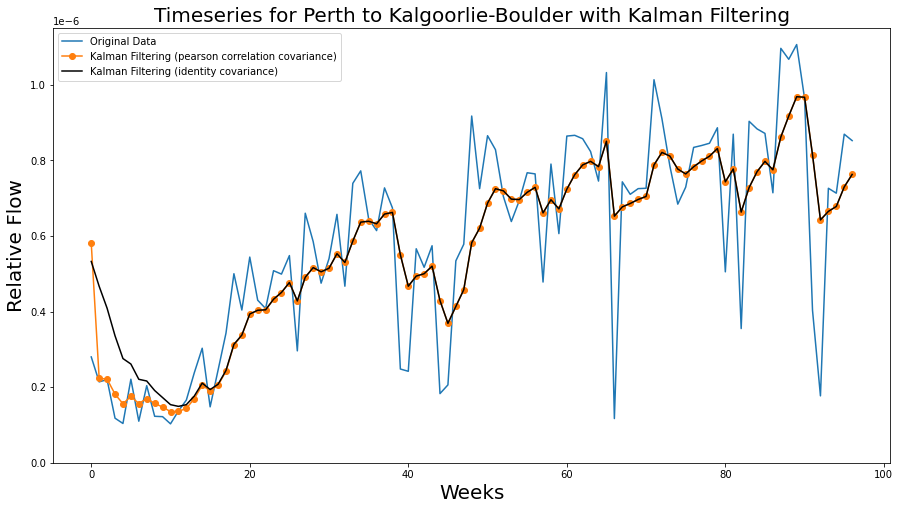

In [60]:
# Check some differenct edges and plot to see what you get!
v = 3
ts = timeseries_vector(v)
plt.figure(figsize = (15,8))
plt.plot(ts, label = 'Original Data')
fil = []
for i in range(weeks):
    fil.append(up[i][v])
plt.plot(fil, marker ='o',label = 'Kalman Filtering (pearson correlation covariance)')
f, kg, inn = filtering(ts, diag*2,diag/5, mean, std)
plt.plot(f, color = 'black',label = 'Kalman Filtering (identity covariance)')
plt.title('Timeseries for Perth to Kalgoorlie-Boulder with Kalman Filtering', fontsize = 20)
plt.xlabel('Weeks', fontsize = 20)
plt.ylabel('Relative Flow',fontsize = 20)
plt.ylim(0,0.00000115)
plt.legend()

In [58]:
# Check there are no negative entries remaining
for v in range(big):
    for i in range(weeks):
        if up[i][v] < 0:
            print(v,i, up[i][v])

In [32]:
# Rearrange data into the usable form, write it all into the files
new_data = []
for j in range(weeks):
    n = []
    for i in range(b):
        nd = []
        for k in range(b):
            nd.append(up[j][i*b+k])
        n.append(nd)
    new_data.append(n)

for j in range(weeks):
    df = pd.DataFrame(new_data[j])
    df.to_csv("/Volumes/HardDrive/New_Workflow/kalman_all_44_<250/"+wa_flow[j],index = False, header = False)

**Checking the sum of all edges every week:**

In [8]:
weekdates = []
for name in wa_flow:
    weekdates.append(name[16:18]+'/'+name[14:16])

In [9]:
months = []
for name in wa_flow:
    m = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    mo = int(name[14:16])
    ye = int(name[12:14])
    
    date = str(m[mo-1]) + ' ' + str(ye)
    if date in months:
        months.append('')
    else:
        months.append(date)

In [11]:
weeks = 97

Text(0.5, 0, 'Date')

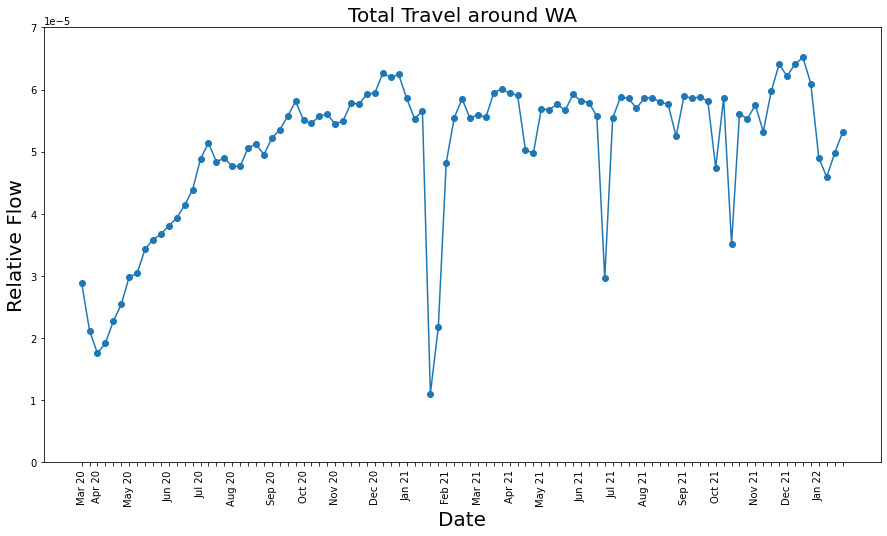

In [13]:
summ = []
for i in range(weeks):
    a = 0
    for j in d[str(i)].values.tolist():
        for k in j:
            a += k
    summ.append(a)
plt.figure(figsize = (15,8))
plt.plot(summ, marker = 'o')
plt.title('Total Travel around WA',fontsize = 20)
plt.ylim(0,0.00007)
plt.ylabel('Relative Flow', fontsize = 20)
plt.xticks([i for i in range(len(weekdates))],months,rotation = 90,fontsize = 10)
plt.xlabel('Date', fontsize = 20)

In [14]:
# Use this if just needing to plot results of Kalman filtering.

In [15]:
import networkx as nx
from numpy import genfromtxt

In [16]:
# Function to read in a text file into an array
def readFile(fileName):
        fileObj = open(fileName, "r") #opens the file in read mode
        words = fileObj.read().splitlines() #puts the file into an array
        arr = []
        for item in words:
            arr.append(item.split('\t'))
        fileObj.close()
        return arr

In [18]:
waloc = pd.read_csv('/Users/Yuval/Desktop/Thesis/all-wa-pos.csv')#use this for all 297 towns
waloc = waloc.loc[waloc['Population'] >0]
# When doing big towns
waloc = waloc[:58]
# When ignoring sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Yanchep') & (waloc['City / Town'] != 'Bullsbrook') &
                  (waloc['City / Town'] != 'Mundijong') & (waloc['City / Town'] != 'Serpentine') &
                 (waloc['City / Town'] != 'Two Rocks') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring rural sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Pinjarra') & (waloc['City / Town'] != 'Drummond Cove') &
                  (waloc['City / Town'] != 'Bridgetown') & (waloc['City / Town'] != 'Binningup') &
                 (waloc['City / Town'] != 'Dampier') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring 0 flow towns
waloc = waloc.loc[(waloc['City / Town'] != 'Kununurra') & (waloc['City / Town'] != 'Derby') &
                  (waloc['City / Town'] != 'Boddington-Ranford') & (waloc['City / Town'] != 'Wyndham')]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])


# Read in the network, generate a plot for it
my_data = genfromtxt('/Volumes/HardDrive/New_Workflow/44_towns_network/Town_Flow_20200322_20200328.csv', delimiter=',')
A = nx.from_numpy_matrix(my_data)
A = nx.DiGraph(A)

# Assign labels to each town based on waloc
#towns = [item[0] for item in waloc]
towns = list(waloc['City / Town'])
labeldict = {}
for node in list(A.nodes()):
    labeldict[node] = towns[node]
    
towns = list(labeldict.values())
edges = []
for t in towns:
    for o in towns:
        edges.append(t +' to ' + o)

In [24]:
for i in range(0,1000):
    point = 0
    ts = timeseries_vector(i)
    for t in ts:
        if t > 0:
            point+=1
    if point/len(ts) > 0.5:
        print(i, edges[i])

3 Perth to Kalgoorlie-Boulder
6 Perth to Karratha
7 Perth to Broome
8 Perth to Port Hedland
11 Perth to Northam
14 Perth to Newman
19 Perth to Tom Price
37 Perth to Paraburdoo
43 Perth to Mandurah
49 Bunbury to Busselton
54 Bunbury to Collie
65 Bunbury to Harvey
69 Bunbury to Donnybrook
72 Bunbury to Capel
108 Geraldton to Port Denison-Dongara
132 Kalgoorlie-Boulder to Perth
162 Kalgoorlie-Boulder to Kambalda West
199 Albany to Denmark
207 Albany to Little Grove
221 Busselton to Bunbury
233 Busselton to Dunsborough
248 Busselton to Capel
254 Busselton to Cowaramup
264 Karratha to Perth
297 Karratha to Wickham
308 Broome to Perth
352 Port Hedland to Perth
441 Collie to Bunbury
484 Northam to Perth
508 Northam to York
562 Margaret River to Cowaramup
577 Dunsborough to Busselton
616 Newman to Perth
635 Newman to Tom Price
773 Manjimup to Donnybrook
832 Katanning to Kojonup
836 Tom Price to Perth
850 Tom Price to Newman
873 Tom Price to Paraburdoo
882 Port Denison-Dongara to Geraldton
925 

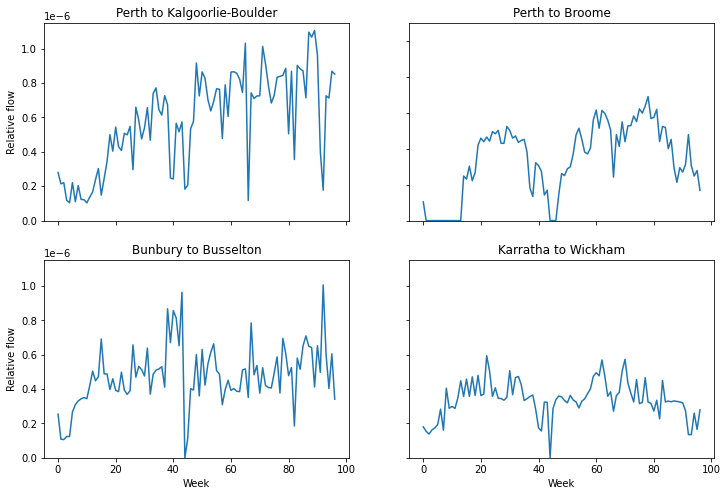

In [27]:
fig, axs = plt.subplots(2, 2,figsize = (12,8))
ts = timeseries_vector(3)
axs[0, 0].plot(ts)
axs[0, 0].set_title('Perth to Kalgoorlie-Boulder')
axs[0, 0].set_ylim(0,0.00000115)
ts = timeseries_vector(7)
axs[0, 1].plot(ts)
axs[0, 1].set_title('Perth to Broome')
axs[0, 1].set_ylim(0,0.0000011)
ts = timeseries_vector(49)
axs[1, 0].plot(ts)
axs[1, 0].set_title('Bunbury to Busselton')
axs[1, 0].set_ylim(0,0.00000115)
ts = timeseries_vector(297)
axs[1, 1].plot(ts)
axs[1, 1].set_title('Karratha to Wickham')
axs[1, 1].set_ylim(0,0.00000115)

for ax in axs.flat:
    ax.set(xlabel='Week', ylabel='Relative flow')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [28]:
#Now plot with the Kalman filtering

In [61]:
fl = sorted(os.listdir("/Volumes/HardDrive/New_Workflow/44_towns_network/"))
wa_flow = []
for item in fl:
    if '._' not in item:
        wa_flow.append(item)
        
d = {}
for i in range(len(wa_flow)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/kalman_all_44/"+wa_flow[i], header = None)

# Define some global variables
b = 44
big =44**2
weeks = len(d)

allvals1 = []
for i in range(len(d.values())):
    l = d[str(i)].values.tolist()
    av = []
    for i in l:
        for k in i:
            av.append(k)
            allvals1.append(k)

#Create a vector of all entries of a particular edge during all weeks from allvals
def timeseries_vector1(x): 
    timeseries = []
    for i in range(weeks):
        timeseries.append(allvals1[x+(big)*i])
    return timeseries

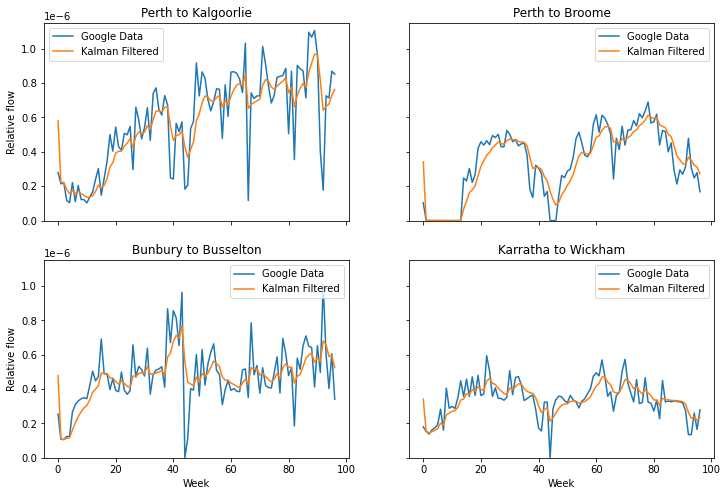

In [62]:
fig, axs = plt.subplots(2, 2,figsize = (12,8))
ts = timeseries_vector(3)
ts1 = timeseries_vector1(3)
axs[0, 0].plot(ts,label = 'Google Data')
axs[0, 0].plot(ts1, label = 'Kalman Filtered')
axs[0, 0].set_title('Perth to Kalgoorlie')
axs[0, 0].set_ylim(0,0.00000115)
axs[0, 0].legend()
ts = timeseries_vector(7)
ts1 = timeseries_vector1(7)
axs[0, 1].plot(ts,label = 'Google Data')
axs[0, 1].plot(ts1, label = 'Kalman Filtered')
axs[0, 1].set_title('Perth to Broome')
axs[0, 1].set_ylim(0,0.00000115)
axs[0, 1].legend()
ts = timeseries_vector(49)
ts1 = timeseries_vector1(49)
axs[1, 0].plot(ts,label = 'Google Data')
axs[1, 0].plot(ts1, label = 'Kalman Filtered')
axs[1, 0].set_title('Bunbury to Busselton')
axs[1, 0].set_ylim(0,0.00000115)
axs[1, 0].legend(loc = 'upper right')
ts = timeseries_vector(297)
ts1 = timeseries_vector1(297)
axs[1, 1].plot(ts,label = 'Google Data')
axs[1, 1].plot(ts1, label = 'Kalman Filtered')
axs[1, 1].set_title('Karratha to Wickham')
axs[1, 1].set_ylim(0,0.00000115)
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Week', ylabel='Relative flow')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## With Stochasticising

In [66]:
# For kalman filtered
fl = sorted(os.listdir("/Volumes/HardDrive/New_Workflow/44_towns_network/"))
wa_flow = []
for item in fl:
    if '._' not in item:
        wa_flow.append(item)
        
d = {}
for i in range(len(wa_flow)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/kalman_all_44/"+wa_flow[i], header = None)

# Define some global variables
b = 44
big =44**2
weeks = len(d)

allvals1 = []
for i in range(len(d.values())):
    l = d[str(i)].values.tolist()
    av = []
    for i in l:
        for k in i:
            av.append(k)
            allvals1.append(k)

#Create a vector of all entries of a particular edge during all weeks from allvals
def timeseries_vector1(x): 
    timeseries = []
    for i in range(weeks):
        timeseries.append(allvals1[x+(big)*i])
    return timeseries

In [67]:
# For stochastic
# For kalman filtered
fl = sorted(os.listdir("/Volumes/HardDrive/New_Workflow/stochastic_44/"))
wa_flow = []
for item in fl:
    if '._' not in item:
        wa_flow.append(item)
        
d = {}
for i in range(len(wa_flow)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/stochastic_44/"+wa_flow[i], header = None)

# Define some global variables
b = 44
big =44**2
weeks = len(d)

allvals2 = []
for i in range(len(d.values())):
    l = d[str(i)].values.tolist()
    av = []
    for i in l:
        for k in i:
            av.append(k)
            allvals2.append(k)

#Create a vector of all entries of a particular edge during all weeks from allvals
def timeseries_vector2(x): 
    timeseries = []
    for i in range(weeks):
        timeseries.append(allvals2[x+(big)*i])
    return timeseries

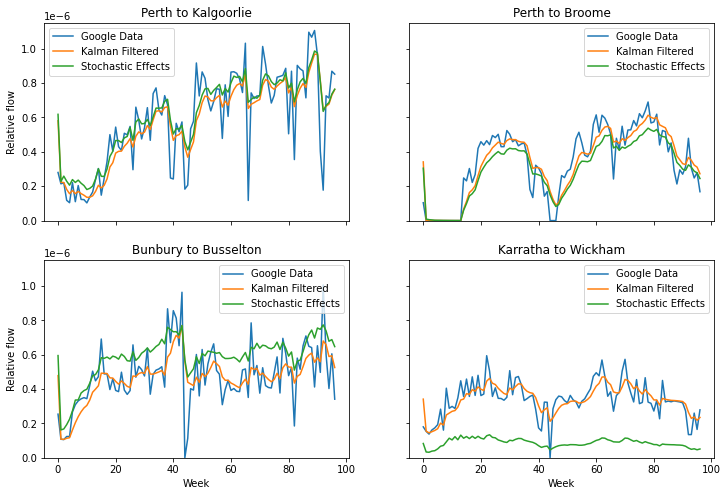

In [68]:
fig, axs = plt.subplots(2, 2,figsize = (12,8))
ts = timeseries_vector(3)
ts1 = timeseries_vector1(3)
ts2 = timeseries_vector2(3)
axs[0, 0].plot(ts,label = 'Google Data')
axs[0, 0].plot(ts1, label = 'Kalman Filtered')
axs[0, 0].plot(ts2, label = 'Stochastic Effects')
axs[0, 0].set_title('Perth to Kalgoorlie')
axs[0, 0].set_ylim(0,0.00000115)
axs[0, 0].legend()
ts = timeseries_vector(7)
ts1 = timeseries_vector1(7)
ts2 = timeseries_vector2(7)
axs[0, 1].plot(ts,label = 'Google Data')
axs[0, 1].plot(ts1, label = 'Kalman Filtered')
axs[0, 1].plot(ts2, label = 'Stochastic Effects')
axs[0, 1].set_title('Perth to Broome')
axs[0, 1].set_ylim(0,0.00000115)
axs[0, 1].legend()
ts = timeseries_vector(49)
ts1 = timeseries_vector1(49)
ts2 = timeseries_vector2(49)
axs[1, 0].plot(ts,label = 'Google Data')
axs[1, 0].plot(ts1, label = 'Kalman Filtered')
axs[1, 0].plot(ts2, label = 'Stochastic Effects')
axs[1, 0].set_title('Bunbury to Busselton')
axs[1, 0].set_ylim(0,0.00000115)
axs[1, 0].legend(loc = 'upper right')
ts = timeseries_vector(297)
ts1 = timeseries_vector1(297)
ts2 = timeseries_vector2(297)
axs[1, 1].plot(ts,label = 'Google Data')
axs[1, 1].plot(ts1, label = 'Kalman Filtered')
axs[1, 1].plot(ts2, label = 'Stochastic Effects')
axs[1, 1].set_title('Karratha to Wickham')
axs[1, 1].set_ylim(0,0.00000115)
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Week', ylabel='Relative flow')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [69]:
d = {}
for i in range(len(wa_flow)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/kalman_all_44/"+wa_flow[i], header = None)
    
counter = 0
for i in range(len(d.values())):
    l = d[str(i)].values.tolist()
    av = []
    for i in l:
        for k in i:
            if k >0:
                counter+=1
print(counter/97)

128.16494845360825


In [70]:
d = {}
for i in range(len(wa_flow)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/stochastic_44/"+wa_flow[i], header = None)
    
counter = 0
for i in range(len(d.values())):
    l = d[str(i)].values.tolist()
    av = []
    for i in l:
        for k in i:
            if k >0:
                counter+=1
print(counter/97)

1648.4329896907216


In [73]:
44**2-44

1892

In [57]:
max(allvals2)*8999716586

122824.49360710997

In [84]:
97*58*58

326308